In [1]:
import sqlite3
import json
import joblib 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing, tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import sklearn.ensemble as ske
from sklearn.model_selection import train_test_split, cross_validate
from xgboost import XGBClassifier

## Load Data into Pandas DataFrame

In [78]:
df = pd.read_csv("../data/1.88_Million_US_Wildfires.csv", low_memory=False)
del df["Unnamed: 0"]

In [79]:
df.shape

(1880465, 11)

*1.88 Million Data is ready for analyze*

### Write cleansed DataFrame to SQLite

It will be needed for the customer to do analysis in the Databse by using the Web Application

In [4]:
conn = sqlite3.connect('../data/wildfires.sqlite')
df.to_sql('Fires', conn, if_exists='replace', index=False)
conn.close()

## Data Cleaning Process

**Not all columns necessary, so let's drop unnecessary columns**

In [80]:
# I don't think that we need to have "FIRE_SIZE_CLASS" and "FIPS_NAME" anymore. They were kept for only analyze purpose.
df = df.drop(["FIRE_SIZE_CLASS", "COUNTY", "FIPS_NAME", "STAT_CAUSE_CODE"], axis=1)

In [81]:
df.head()

,FIRE_YEAR,DISCOVERY_DATE,STAT_CAUSE_DESCR,FIRE_SIZE,LATITUDE,LONGITUDE,STATE
0,2005,2453403.5,Miscellaneous,0.10,40.036944,-121.005833,CA
1,2004,2453137.5,Lightning,0.25,38.933056,-120.404444,CA
2,2004,2453156.5,Debris Burning,0.10,38.984167,-120.735556,CA
3,2004,2453184.5,Lightning,0.10,38.559167,-119.913333,CA
4,2004,2453184.5,Lightning,0.10,38.559167,-119.933056,CA


In [82]:
df.shape

(1880465, 7)

*We have 7 columns in our new DataFrame*

### Get additional features

The DISCOVERY_DATE field is in Julian Date format. I can convert this field to format we use everyday

In [83]:
df['DATE'] = pd.to_datetime(df['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')

In [84]:
# Separate Month and Day_of_week into different columns
df['MONTH'] = pd.DatetimeIndex(df['DATE']).month
df['DAY_OF_WEEK'] = df['DATE'].dt.day_name()

In [85]:
df.head()

,FIRE_YEAR,DISCOVERY_DATE,STAT_CAUSE_DESCR,FIRE_SIZE,LATITUDE,LONGITUDE,STATE,DATE,MONTH,DAY_OF_WEEK
0,2005,2453403.5,Miscellaneous,0.10,40.036944,-121.005833,CA,2005-02-02,2,Wednesday
1,2004,2453137.5,Lightning,0.25,38.933056,-120.404444,CA,2004-05-12,5,Wednesday
2,2004,2453156.5,Debris Burning,0.10,38.984167,-120.735556,CA,2004-05-31,5,Monday
3,2004,2453184.5,Lightning,0.10,38.559167,-119.913333,CA,2004-06-28,6,Monday
4,2004,2453184.5,Lightning,0.10,38.559167,-119.933056,CA,2004-06-28,6,Monday


In [86]:
# We don't need DATE field anymore
df = df.drop('DATE',axis=1)

### Missing Values

In [87]:
# Count null values under entire DataFrame
df.isna().sum().sum()

0

*There is no null value in our dataset"

### Data Types

In [88]:
df.dtypes

FIRE_YEAR             int64
DISCOVERY_DATE      float64
STAT_CAUSE_DESCR     object
FIRE_SIZE           float64
LATITUDE            float64
LONGITUDE           float64
STATE                object
MONTH                 int64
DAY_OF_WEEK          object
dtype: object

*Everything looks fine at data types*

### Duplicated Values

In [89]:
# Check whether any duplicated values exist
df.duplicated(keep='first').sum()

6468

*There is 6468 duplicated data in our DataFrame*

In [90]:
# Delete duplicated values
# Keep first duplicate row
df = df.drop_duplicates(keep='last')

In [91]:
# See the new data count in our Data
df.shape

(1873997, 9)

### Perform Exploratory Data Analysis (EDA)

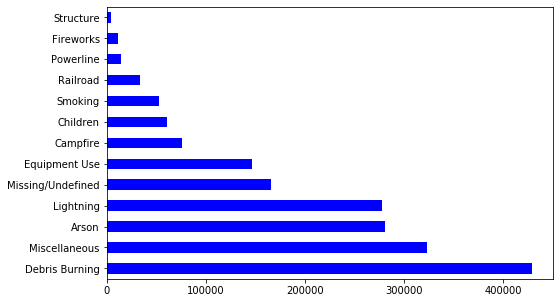

In [92]:
plt.rcParams["figure.figsize"] = (8,5)

df['STAT_CAUSE_DESCR'].value_counts().plot(kind='barh', color='b')
plt.show()

*There are 13 causes listed in the dataset.*
- Wildfires occurs due to Debris Burning mostly

### Correlation Matrix

Let's draw correlation matrix to understand the relationship between features (if there is any)
- First, we need to convert all features to numeric values. This will also be helpful while traning the model for prediction

In [93]:
le = preprocessing.LabelEncoder()

# Transform String values to numeric values
df['STATE'] = le.fit_transform(df['STATE'])
df['DAY_OF_WEEK'] = le.fit_transform(df['DAY_OF_WEEK'])

# This one also be target/label column, so we need to create label mapping for cause prediction
df['STAT_CAUSE_DESCR'] = le.fit_transform(df['STAT_CAUSE_DESCR'])

In [94]:
le_name_mapping = dict(zip(le.transform(le.classes_), le.classes_))
le_name_mapping

{0: 'Arson',
 1: 'Campfire',
 2: 'Children',
 3: 'Debris Burning',
 4: 'Equipment Use',
 5: 'Fireworks',
 6: 'Lightning',
 7: 'Miscellaneous',
 8: 'Missing/Undefined',
 9: 'Powerline',
 10: 'Railroad',
 11: 'Smoking',
 12: 'Structure'}

In [24]:
# Save Label encoder int pkl file for using in restful api
joblib.dump(le,'../models/labelEncoder.joblib',compress=9)

['../models/labelEncoder.joblib']

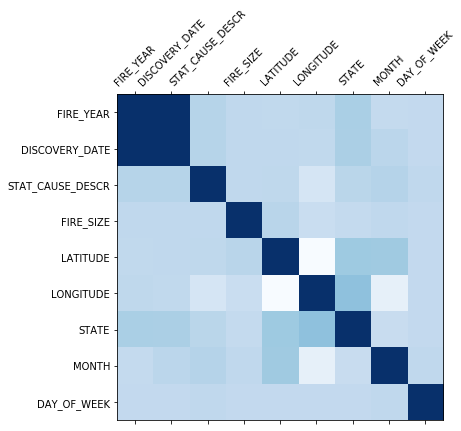

In [19]:
corr = df.corr()

fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(corr, cmap=plt.cm.Blues)
plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)    
plt.show()

**Darker shades mean stronger correlation, and white ones mean zero correlation**

- There is correlation between STATE and LATITUDE
- There is less correlation between MONTH and and LATITUDE
- Beyond that, we cannot say something certain about correlation among features

## Preparing the Train Data

The goal is to predict cause of the wildfire, so we need "STAT_CAUSE_DESCR_ENC" as label/target and others as features

In [20]:
X = df.drop(['STAT_CAUSE_DESCR'], axis=1)
y = df['STAT_CAUSE_DESCR']

In [21]:
print(X.shape)
print(y.shape)

(1873997, 8)
(1873997,)


In [22]:
# Scaling reduced the success rate in my case so I commented out
# define min max scaler
scaler = MinMaxScaler()
# transform data
X = scaler.fit_transform(X)

In [23]:
#30% for testing, 70% for training
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0, stratify = y)

The stratify parameter will ensure that the train and test split has the same class distribution ratio as the original dataset. It is crucial in the case of imbalanced datasets. Otherwise, it might happen that the training data only consists of the majority class.

## Hyperparameter Optimization for DecisionTreeClassifier and Training

In [30]:
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

In [50]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [55]:
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  3.8min finished


GridSearchCV(cv=4, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=14,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                       

In [56]:
grid_search.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=20, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=14, splitter='best')

In [31]:
clf = tree.DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                                  max_depth=20, max_features=None, max_leaf_nodes=None,
                                  min_impurity_decrease=0.0, min_impurity_split=None,
                                  min_samples_leaf=20, min_samples_split=2,
                                  min_weight_fraction_leaf=0.0, presort='deprecated',
                                  random_state=14, splitter='best')
clf = clf.fit(X_train, y_train)

In [32]:
y_pred = clf.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, y_pred))

Accuracy:  0.5573532550693703


In [25]:
# Use Cross Validation to measure the success of the model
cv = cross_validate(clf, X_train, y_train, cv=5)

In [26]:
cv["test_score"].mean()

0.5495918967225463

## Hyperparameter Optimization for RandomForrest and Training

### Grid Search for Hyperparameter Optimization

In [27]:
rf_Model = RandomForestClassifier()

rf_Grid = GridSearchCV(estimator = rf_Model, param_grid = param_grid, cv = 3, verbose=2, n_jobs = 4)

In [26]:
rf_Grid.fit(X_train, y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=4,
             param_grid={'max_depth': [2, 4], 'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100]},
             verbose=2)

In [27]:
rf_Grid.best_params_

{'max_depth': 4, 'min_samples_split': 2, 'n_estimators': 50}

**So let's create a model with best parameters**

In [36]:
# Create model
model = ske.RandomForestClassifier(max_depth = 4, min_samples_split = 2, n_estimators = 50)

In [37]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy_score(y_test, y_pred)

0.37176627534685164

## Hyperparameter Optimization for XGBoost and Training

#### Prepare parameters

In [42]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'subsample': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [43]:
estimator = XGBClassifier(learning_rate=0.1, n_estimators=150, objective='multi:softmax', tree_method = "hist")

In [ ]:
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(estimator, param_distributions=params, 
                                   n_iter=param_comb,
                                   n_jobs=4, 
                                   cv=skf.split(X_train,y_train), 
                                   verbose=3, 
                                   random_state=14)

# Here we go
random_search.fit(X_train, y_train)

In [ ]:
random_search.best_estimator_

In [33]:
# fit model
model = XGBClassifier(objective = 'multi:softmax', num_class = 8, tree_method = "hist", learning_rate = 0.3)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.3, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_class=8, num_parallel_tree=1,
              objective='multi:softmax', predictor='auto', random_state=0, ...)

In [34]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [35]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 55.67%


In [102]:
# Use Cross Validation to measure the success of the model
cv = cross_validate(model, X_train, y_train, cv=5)

In [103]:
cv["test_score"].mean()

0.560889597933641

**SEEMS THAT XGBOOST IS THE BEST MODEL AMONG THE RANDOM FORREST AND DECISION TREE. SO, I'LL MOVE FORWARD WITH XGBOOST**

### Save model

In [23]:
# save in pkl format
model.save_model("../models/model_xgb.pkl")

## EXAMPLE USAGE

### Load model

In [27]:
# Load model to see if it works properly
model2 = XGBClassifier()
model2.load_model("../models/model.pkl")

### Make Prediction

In [107]:
# for idx, row in df[:10000].iterrows():
#     features = np.asarray([[row["FIRE_YEAR"], 
#                             row["DISCOVERY_DATE"], row["FIRE_SIZE"], 
#                             row["LATITUDE"], row["LONGITUDE"], 
#                             row["STATE"], row["MONTH"], row["DAY_OF_WEEK"]]])
#     pred = model2.predict(features)
#     print(idx, ": ", le_name_mapping[pred[0]])
    
features = np.asarray([[2004, 2453440.5, 0.60, 35.228333, -82.884444, 11, 3, 11]])
pred = model2.predict(features)
print(pred)
le_name_mapping[pred[0]]

[3]


'Debris Burning'